<a href="https://colab.research.google.com/github/pushan9/Colab-notebook/blob/main/Sentiment_Analysis_using_Logistic_regression_on_Restaurant_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Agenda for today:
# 1. Sentiment Analysis using Logistic regression on Restaurant Reviews
# 2. TextBlob library

In [ ]:
# 1. Sentiment Analysis using Logistic regression on Restaurant Reviews
# Lets do the necessary imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns # statistical data visualization
import nltk # natural language toolkit
import re # regular expressions
from nltk.corpus import stopwords # stopwords
from nltk.stem.porter import PorterStemmer # stemming
from nltk.stem import WordNetLemmatizer # lemmatization
from sklearn.feature_extraction.text import CountVectorizer # bag of words (convert text to feature vectors)
from sklearn.model_selection import train_test_split # train test split
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report # model evaluation
import warnings # to ignore warnings
warnings.filterwarnings('ignore') # ignore warnings

In [ ]:
dataset = pd.read_csv("https://raw.githubusercontent.com/ingledarshan/upGrad_Darshan/main/Restaurant_Reviews.tsv",
                     delimiter='\t', quoting=3)

# Let's take a look at the dataset
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [ ]:
# to see the complete rows, use the following command
pd.set_option('display.max_colwidth', None)
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1


In [ ]:
# Lets look at the shape of the dataset
dataset.shape

(1000, 2)

In [ ]:
# Lets see the information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
# Lets find the number of missing values in the dataset
dataset.isnull().sum().sort_values(ascending=False)

,0
Review,0
Liked,0


In [ ]:
# Lets check the imbalance in the target variable
dataset['Liked'].value_counts()

,count
Liked,
1,500
0,500


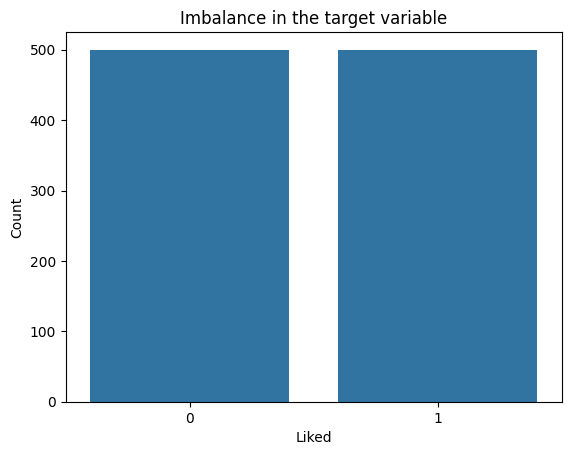

In [ ]:
# Lets plot the imbalance in the target variable
sns.countplot(x='Liked', data=dataset)
plt.title('Imbalance in the target variable')
plt.xlabel('Liked')
plt.ylabel('Count')
plt.show()

In [ ]:
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1


In [ ]:
# Comprehensive negation words list
negation_words = {
    # Basic negations
    'not', 'no', 'never', 'none', 'nothing', 'nobody', 'nowhere', 'neither',

    # Contractions with "not"
    'can\'t', 'cannot', 'won\'t', 'wouldn\'t', 'shouldn\'t', 'couldn\'t',
    'mustn\'t', 'needn\'t', 'daren\'t', 'oughtn\'t',

    # "do" contractions
    'don\'t', 'doesn\'t', 'didn\'t',

    # "be" contractions
    'isn\'t', 'aren\'t', 'wasn\'t', 'weren\'t',

    # "have" contractions
    'haven\'t', 'hasn\'t', 'hadn\'t',

    # "will/would" negations
    'won\'t', 'wouldn\'t',

    # Modal negations
    'can\'t', 'couldn\'t', 'shouldn\'t', 'mustn\'t', 'needn\'t', 'mightn\'t',

    # Adverbs of negation/low frequency
    'never', 'rarely', 'seldom', 'hardly', 'barely', 'scarcely',
    'infrequently', 'uncommonly',

    # Degree negations
    'barely', 'hardly', 'scarcely', 'little', 'few',

    # Prefix negations (common ones)
    'non', 'un', 'in', 'im', 'ir', 'il', 'dis', 'mis', 'anti', 'de',

    # Negative expressions
    'by no means', 'in no way', 'on no account', 'under no circumstances',
    'at no time', 'in no case', 'not at all', 'not in the least',
    'not a bit', 'not once', 'not ever', 'not yet',

    # Implicit negations
    'without', 'lacking', 'missing', 'absent', 'void', 'devoid',
    'deprived', 'bereft', 'minus', 'excluding', 'except',

    # Negative adjectives/adverbs that imply negation
    'impossible', 'unable', 'incapable', 'unlikely', 'improbable',
    'doubtful', 'questionable', 'uncertain', 'unsure',

    # Words that negate following words
    'fail', 'failed', 'failure', 'refuse', 'refused', 'denial', 'deny',
    'reject', 'rejected', 'avoid', 'prevent', 'stop', 'cease',

    # Informal/slang negations
    'nope', 'nah', 'nay', 'uh-uh', 'no way', 'not really',

    # Comparative negations
    'less', 'fewer', 'worse', 'worst', 'inferior', 'below', 'under',
    'beneath', 'lower', 'minimal', 'minimum',

    # Conditional negations
    'unless', 'except', 'but', 'however', 'although', 'though', 'despite',
    'nevertheless', 'nonetheless', 'yet', 'still',

    # Words that often precede negative sentiment
    'unfortunately', 'sadly', 'regrettably', 'disappointingly',
    'worryingly', 'alarmingly', 'shockingly', 'surprisingly'
}

print(f"Total negation words: {len(negation_words)}")
print("Sample negation words:")
print(list(negation_words)[:20])

Total negation words: 128
Sample negation words:
['inferior', 'by no means', 'below', "doesn't", 'un', "needn't", 'reject', 'still', 'rarely', 'nobody', "daren't", 'doubtful', "don't", 'non', 'unlikely', 'worse', 'hardly', "mightn't", 'void', "hasn't"]


In [ ]:
dataset['Review'][0]
# After processing the Review: "wow love place"

'Wow... Loved this place.'

In [ ]:
# Lets process a sample text
import nltk
nltk.download('wordnet')
text = dataset['Review'][0] # "Wow... Loved this place."
print(f"Original text: {text}")
# Lower case
text = text.lower()
print(f"Lower case: {text}")
# Remove numbers and special characters
text = re.sub('[^a-zA-Z]', ' ', text)
print(f"Removed numbers and special characters: {text}")
# Tokenization
text = text.split()
print(f"Tokenized text: {text}")
# Remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
custom_stopwords = stopwords - negation_words  # Retain negation words
print(f"=>Custom stopwords (total {len(custom_stopwords)}): {custom_stopwords}")
text = [word for word in text if word not in custom_stopwords]
print(f"Text after removing stopwords: {text}")
# Stemming
ps = PorterStemmer()
text_stemmed = [ps.stem(word) for word in text]
print(f"Text after stemming: {text_stemmed}")
# Lemmatization
lemmatizer = WordNetLemmatizer()
text_lemmatized = [lemmatizer.lemmatize(word) for word in text]
print(f"Text after lemmatization: {text_lemmatized}")
# Join the stemmed words back to form the sentence
text = ' '.join(text_stemmed)
print(f"text after stemming is joined: {text}")
# Join the lemmatized words back to form the sentence
text = ' '.join(text_lemmatized)
print(f"text after lemmatization is joined: {text}")

[nltk_data] Downloading package wordnet to /root/nltk_data...


Original text: Wow... Loved this place.
Lower case: wow... loved this place.
Removed numbers and special characters: wow    loved this place 
Tokenized text: ['wow', 'loved', 'this', 'place']
=>Custom stopwords (total 174): {'are', 'doing', 'me', 'once', 'mustn', 't', 'ours', 'do', 'd', 'isn', 'too', "he'll", 'have', 'these', 'ma', 'if', 'while', 'm', 'aren', 'both', 'each', 'did', 'them', "they're", "that'll", 'been', 'at', "i'll", 'does', "should've", 'theirs', 'until', 'shan', 'most', 'wasn', 'which', "you've", 'by', 'needn', 'over', 'only', 'down', "i'd", 'will', 'couldn', 'doesn', 'mightn', "she'd", 's', 'hasn', 'being', 'your', "you'll", 'a', "it's", 'just', 'y', 'there', 'its', 'off', 'yourself', "you're", 'be', 'ain', 'up', 'don', 'during', 'after', 're', 'has', 'why', 'himself', 'nor', 'didn', 'him', 'such', 'then', 'ourselves', 'an', "it'll", 'against', "we've", 'yours', 'the', 'further', 've', "we'd", 'am', 'hers', 'you', "i'm", 'o', "she'll", 'of', 'about', 'some', 'when', 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text after lemmatization: ['wow', 'loved', 'place']
text after stemming is joined: wow love place
text after lemmatization is joined: wow loved place


In [ ]:
dataset['Review'][1]

'Crust is not good.'

In [ ]:
# Lets process a sample text
text = dataset['Review'][1] # "Crust is not good."
print(f"Original text: {text}")
# Lower case
text = text.lower()
print(f"Lower case: {text}")
# Remove numbers and special characters
text = re.sub('[^a-zA-Z]', ' ', text)
print(f"Removed numbers and special characters: {text}")
# Tokenization
text = text.split()
print(f"Tokenized text: {text}")
# Remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
custom_stopwords = stopwords - negation_words  # Retain negation words
text = [word for word in text if word not in custom_stopwords]
print(f"Text after removing stopwords: {text}")
# Stemming
ps = PorterStemmer()
text_stemmed = [ps.stem(word) for word in text]
print(f"Text after stemming: {text_stemmed}")
# Lemmatization
lemmatizer = WordNetLemmatizer()
text_lemmatized = [lemmatizer.lemmatize(word) for word in text]
print(f"Text after lemmatization: {text_lemmatized}")
# Join the stemmed words back to form the sentence
text = ' '.join(text_stemmed)
print(f"text after stemming is joined: {text}")
# Join the lemmatized words back to form the sentence
text = ' '.join(text_lemmatized)
print(f"text after lemmatization is joined: {text}")

Original text: Crust is not good.
Lower case: crust is not good.
Removed numbers and special characters: crust is not good 
Tokenized text: ['crust', 'is', 'not', 'good']
Text after removing stopwords: ['crust', 'not', 'good']
Text after stemming: ['crust', 'not', 'good']
Text after lemmatization: ['crust', 'not', 'good']
text after stemming is joined: crust not good
text after lemmatization is joined: crust not good


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1


In [ ]:
# Lets do the above steps for the entire dataset
corpus_for_stemmed = [] # to store the processed reviews
corpus_for_lemmatized = [] # to store the processed reviews
for i in range(0, dataset.shape[0]): # range(0, 1000)
    # Lower case
    text = dataset['Review'][i].lower()
    # Remove numbers and special characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Tokenization
    text = text.split()
    # Remove stopwords
    text = [word for word in text if word not in custom_stopwords]
    # Stemming
    ps = PorterStemmer()
    text_stemmed = [ps.stem(word) for word in text]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text_lemmatized = [lemmatizer.lemmatize(word) for word in text]
    # Join the stemmed words back to form the sentence
    text_stemmed_joined = ' '.join(text_stemmed)
    # Join the lemmatized words back to form the sentence
    text_lemmatized_joined = ' '.join(text_lemmatized)
    # Append the processed review to the corpus
    corpus_for_stemmed.append(text_stemmed_joined)
    corpus_for_lemmatized.append(text_lemmatized_joined)

In [ ]:
# Print the first 5 processed reviews - Stemmed
print("First 5 processed reviews (stemmed):")
for i in range(5):
    print(corpus_for_stemmed[i])

First 5 processed reviews (stemmed):
wow love place
crust not good
not tasti textur nasti
stop late may bank holiday rick steve recommend love
select menu great price


In [ ]:
# Print the first 5 processed reviews - Lemmatized
print("First 5 processed reviews (lemmatized):")
for i in range(5):
    print(corpus_for_lemmatized[i])

First 5 processed reviews (lemmatized):
wow loved place
crust not good
not tasty texture nasty
stopped late may bank holiday rick steve recommendation loved
selection menu great price


In [ ]:
# Now lets convert the text to feature vectors using Bag of Words
# What is Bag of Words?
# Bag of Words is a technique to convert text into feature vectors. It creates a matrix of token counts.
# Each row represents a document (review) and each column represents a token (word).
# The value in each cell represents the count of the token in the document.
# Eg: review 1: "I love this place"
#     review 2: "This place is not good"
# Vocabulary: ["I", "love", "this", "place", "is", "not", "good"]
# Bag of Words representation:
#           I  love  this  place  is  not  good
# review 1  1    1     1     1     0   0     0
# review 2  0    0     1     1     1   1     1
# Total     1    1     2     2     1   1     1
# Sort the vocabulary in descending order of frequency
#          place  this  I  love  is  not  good
# Total     2     2    1    1    1   1     1
# We can see that the most frequent words are "place"

# We will use CountVectorizer from sklearn to create the Bag of Words model
cv1 = CountVectorizer(max_features=1500) # we will use only the top 1500 most frequent words
cv2 = CountVectorizer(max_features=1500) # we will use only the top 1500 most frequent words

X_stemmed = cv1.fit_transform(corpus_for_stemmed).toarray() # feature vectors for stemmed reviews
X_lemmatized = cv2.fit_transform(corpus_for_lemmatized).toarray() # feature vectors for lemmatized reviews
y = dataset['Liked'].values # target variable

In [ ]:
# Lets see X_stemmed
X_stemmed

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X_stemmed.shape # 1000 reviews and 1500 features (words)

(1000, 1500)

In [ ]:
# Print column names
print(cv1.get_feature_names_out())
print()
print(cv2.get_feature_names_out())

['absolut' 'accommod' 'accomod' ... 'yum' 'yummi' 'zero']

['absolutely' 'accordingly' 'accountant' ... 'yum' 'yummy' 'zero']


In [ ]:
X_lemmatized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X_lemmatized.shape # 1000 reviews and 1500 features (words)

(1000, 1500)

In [ ]:
y[:10] # first 10 values of the target variable

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1])

In [ ]:
# Now our X and y are ready for model building

# Lets do train test split
X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(X_stemmed, y, test_size=0.2, random_state=42)

X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = train_test_split(X_lemmatized, y, test_size=0.2, random_state=42)

# Print the shape of the train and test sets
print(f"X_train_stemmed shape: {X_train_stemmed.shape}")
print(f"X_test_stemmed shape: {X_test_stemmed.shape}")
print()
print(f"X_train_lemmatized shape: {X_train_lemmatized.shape}")
print(f"X_test_lemmatized shape: {X_test_lemmatized.shape}")

X_train_stemmed shape: (800, 1500)
X_test_stemmed shape: (200, 1500)

X_train_lemmatized shape: (800, 1500)
X_test_lemmatized shape: (200, 1500)


In [ ]:
# Lets go for model building using Logistic Regression
model_stemmed = LogisticRegression()
model_lemmatized = LogisticRegression()

# Fit the model on the training data
model_stemmed.fit(X_train_stemmed, y_train_stemmed)
model_lemmatized.fit(X_train_lemmatized, y_train_lemmatized)

# Predict on the training data and test data
y_pred_train_stemmed = model_stemmed.predict(X_train_stemmed)
y_pred_test_stemmed = model_stemmed.predict(X_test_stemmed)
y_pred_train_lemmatized = model_lemmatized.predict(X_train_lemmatized)
y_pred_test_lemmatized = model_lemmatized.predict(X_test_lemmatized)

# Evaluate the model - accuracy
print("Model Evaluation for Stemmed Reviews")
print(f"Training Accuracy: {accuracy_score(y_train_stemmed, y_pred_train_stemmed)}")
print(f"Testing Accuracy: {accuracy_score(y_test_stemmed, y_pred_test_stemmed)}")
print("Model Evaluation for Lemmatized Reviews")
print(f"Training Accuracy: {accuracy_score(y_train_lemmatized, y_pred_train_lemmatized)}")
print(f"Testing Accuracy: {accuracy_score(y_test_lemmatized, y_pred_test_lemmatized)}")

Model Evaluation for Stemmed Reviews
Training Accuracy: 0.9725
Testing Accuracy: 0.775
Model Evaluation for Lemmatized Reviews
Training Accuracy: 0.97625
Testing Accuracy: 0.8


In [ ]:
# Reuslts:
# Model Evaluation for Stemmed Reviews
# Training Accuracy: 0.9725
# Testing Accuracy: 0.78
# Model Evaluation for Lemmatized Reviews
# Training Accuracy: 0.98
# Testing Accuracy: 0.8

# Interpretation:
# 1. The training accuracy is very high for both stemmed and lemmatized reviews
# 2. The testing accuracy is also good for both stemmed and lemmatized reviews
# 3. The lemmatized reviews give slightly better accuracy than the stemmed reviews
# 4. We can conclude that lemmatization is a better technique than stemming for this dataset.Liked
# 5. The model is Overfitting as the training accuracy is very high and the testing accuracy is low.

In [ ]:
# Lets go for model building using Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

model_stemmed_dt = DecisionTreeClassifier(max_depth=10)
model_lemmatized_dt = DecisionTreeClassifier(max_depth=10)

model_stemmed_dt.fit(X_train_stemmed, y_train_stemmed)
model_lemmatized_dt.fit(X_train_lemmatized, y_train_lemmatized)

# Predict on the training data and test data
y_pred_train_stemmed_dt = model_stemmed_dt.predict(X_train_stemmed)
y_pred_test_stemmed_dt = model_stemmed_dt.predict(X_test_stemmed)
y_pred_train_lemmatized_dt = model_lemmatized_dt.predict(X_train_lemmatized)
y_pred_test_lemmatized_dt = model_lemmatized_dt.predict(X_test_lemmatized)

# Evaluate the model - accuracy
print("Decision Tree Model Evaluation for Stemmed Reviews")
print(f"Training Accuracy: {accuracy_score(y_train_stemmed, y_pred_train_stemmed_dt)}")
print(f"Testing Accuracy: {accuracy_score(y_test_stemmed, y_pred_test_stemmed_dt)}")
print("Decision Tree Model Evaluation for Lemmatized Reviews")
print(f"Training Accuracy: {accuracy_score(y_train_lemmatized, y_pred_train_lemmatized_dt)}")
print(f"Testing Accuracy: {accuracy_score(y_test_lemmatized, y_pred_test_lemmatized_dt)}")

Decision Tree Model Evaluation for Stemmed Reviews
Training Accuracy: 0.775
Testing Accuracy: 0.67
Decision Tree Model Evaluation for Lemmatized Reviews
Training Accuracy: 0.76625
Testing Accuracy: 0.65


In [ ]:
# Lets go for model building using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model_stemmed_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_lemmatized_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

model_stemmed_rf.fit(X_train_stemmed, y_train_stemmed)
model_lemmatized_rf.fit(X_train_lemmatized, y_train_lemmatized)

# Predict on the training data and test data
y_pred_train_stemmed_rf = model_stemmed_rf.predict(X_train_stemmed)
y_pred_test_stemmed_rf = model_stemmed_rf.predict(X_test_stemmed)
y_pred_train_lemmatized_rf = model_lemmatized_rf.predict(X_train_lemmatized)
y_pred_test_lemmatized_rf = model_lemmatized_rf.predict(X_test_lemmatized)

# Evaluate the model - accuracy
print("Random Forest Model Evaluation for Stemmed Reviews")
print(f"Training Accuracy: {accuracy_score(y_train_stemmed, y_pred_train_stemmed_rf)}")
print(f"Testing Accuracy: {accuracy_score(y_test_stemmed, y_pred_test_stemmed_rf)}")
print("Random Forest Model Evaluation for Lemmatized Reviews")
print(f"Training Accuracy: {accuracy_score(y_train_lemmatized, y_pred_train_lemmatized_rf)}")
print(f"Testing Accuracy: {accuracy_score(y_test_lemmatized, y_pred_test_lemmatized_rf)}")

Random Forest Model Evaluation for Stemmed Reviews
Training Accuracy: 0.865
Testing Accuracy: 0.725
Random Forest Model Evaluation for Lemmatized Reviews
Training Accuracy: 0.88
Testing Accuracy: 0.735


In [ ]:
# Lets go for model building using Support Vector Machine Classifier
from sklearn.svm import SVC

model_stemmed_svc = SVC(kernel='linear', random_state=42)
model_lemmatized_svc = SVC(kernel='linear', random_state=42)

model_stemmed_svc.fit(X_train_stemmed, y_train_stemmed)
model_lemmatized_svc.fit(X_train_lemmatized, y_train_lemmatized)

# Predict on the training data and test data
y_pred_train_stemmed_svc = model_stemmed_svc.predict(X_train_stemmed)
y_pred_test_stemmed_svc = model_stemmed_svc.predict(X_test_stemmed)
y_pred_train_lemmatized_svc = model_lemmatized_svc.predict(X_train_lemmatized)
y_pred_test_lemmatized_svc = model_lemmatized_svc.predict(X_test_lemmatized)

# Evaluate the model - accuracy
print("Support Vector Machine Model Evaluation for Stemmed Reviews")
print(f"Training Accuracy: {accuracy_score(y_train_stemmed, y_pred_train_stemmed_svc)}")
print(f"Testing Accuracy: {accuracy_score(y_test_stemmed, y_pred_test_stemmed_svc)}")
print("Support Vector Machine Model Evaluation for Lemmatized Reviews")
print(f"Training Accuracy: {accuracy_score(y_train_lemmatized, y_pred_train_lemmatized_svc)}")
print(f"Testing Accuracy: {accuracy_score(y_test_lemmatized, y_pred_test_lemmatized_svc)}")

Support Vector Machine Model Evaluation for Stemmed Reviews
Training Accuracy: 0.98875
Testing Accuracy: 0.755
Support Vector Machine Model Evaluation for Lemmatized Reviews
Training Accuracy: 0.9925
Testing Accuracy: 0.77


In [ ]:
# Install xgboost if not already installed
# !pip install xgboost -q

In [ ]:
# Lets go for model building using XGBoost Classifier
from xgboost import XGBClassifier

model_stemmed_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, max_depth=5, max_leaves=10)
model_lemmatized_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, max_depth=5, max_leaves=10)

model_stemmed_xgb.fit(X_train_stemmed, y_train_stemmed)
model_lemmatized_xgb.fit(X_train_lemmatized, y_train_lemmatized)

# Predict on the training data and test data
y_pred_train_stemmed_xgb = model_stemmed_xgb.predict(X_train_stemmed)
y_pred_test_stemmed_xgb = model_stemmed_xgb.predict(X_test_stemmed)
y_pred_train_lemmatized_xgb = model_lemmatized_xgb.predict(X_train_lemmatized)
y_pred_test_lemmatized_xgb = model_lemmatized_xgb.predict(X_test_lemmatized)

# Evaluate the model - accuracy
print("XGBoost Model Evaluation for Stemmed Reviews")
print(f"Training Accuracy: {accuracy_score(y_train_stemmed, y_pred_train_stemmed_xgb)}")
print(f"Testing Accuracy: {accuracy_score(y_test_stemmed, y_pred_test_stemmed_xgb)}")
print("XGBoost Model Evaluation for Lemmatized Reviews")
print(f"Training Accuracy: {accuracy_score(y_train_lemmatized, y_pred_train_lemmatized_xgb)}")
print(f"Testing Accuracy: {accuracy_score(y_test_lemmatized, y_pred_test_lemmatized_xgb)}")

XGBoost Model Evaluation for Stemmed Reviews
Training Accuracy: 0.88875
Testing Accuracy: 0.715
XGBoost Model Evaluation for Lemmatized Reviews
Training Accuracy: 0.87
Testing Accuracy: 0.72


In [ ]:
# # corpus_for_stemmed
# # ' '.join(corpus_for_stemmed)
# ' '.join(corpus_for_stemmed).split()

# Find the most common words in the reviews
from collections import Counter
all_words_stemmed = ' '.join(corpus_for_stemmed).split()
all_words_lemmatized = ' '.join(corpus_for_lemmatized).split()

word_freq_stemmed = Counter(all_words_stemmed)
word_freq_lemmatized = Counter(all_words_lemmatized)

most_common_stemmed = word_freq_stemmed.most_common(10)
most_common_lemmatized = word_freq_lemmatized.most_common(10)

print("Most common words in stemmed reviews:")
print(most_common_stemmed)
print("Most common words in lemmatized reviews:")
print(most_common_lemmatized)

Most common words in stemmed reviews:
[('food', 127), ('not', 116), ('place', 112), ('in', 109), ('good', 95), ('servic', 87), ('great', 70), ('go', 62), ('but', 62), ('back', 61)]
Most common words in lemmatized reviews:
[('food', 127), ('not', 116), ('place', 111), ('in', 109), ('good', 95), ('service', 87), ('great', 70), ('but', 62), ('back', 61), ('time', 55)]


In [ ]:
# Lets plot using WordCloud
!pip install wordcloud -q
from wordcloud import WordCloud

wordcloud_stemmed = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words_stemmed))
wordcloud_lemmatized = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words_lemmatized))

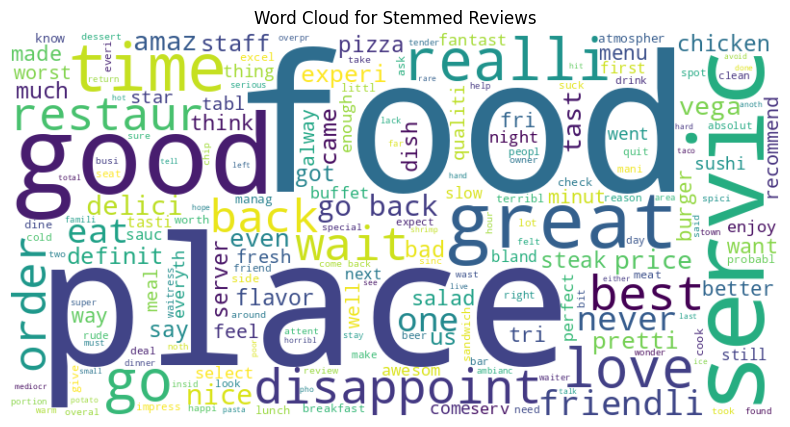

In [ ]:
# Plot the wordcloud for stemmed reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_stemmed, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Stemmed Reviews')
plt.show()

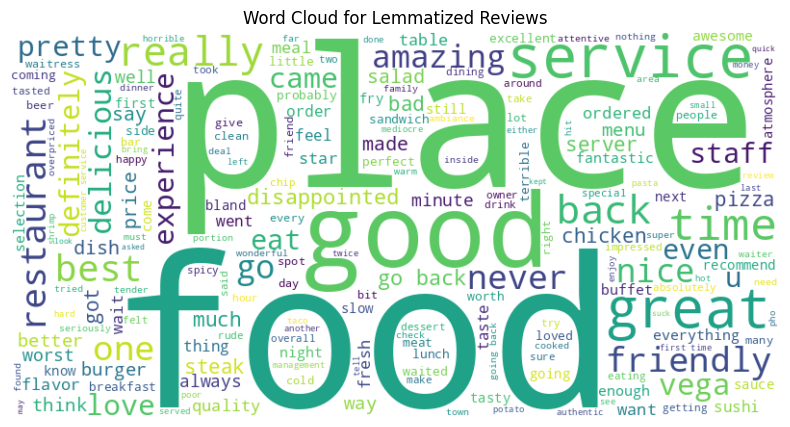

In [ ]:
# Plot the wordcloud for lemmatized reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_lemmatized, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Lemmatized Reviews')
plt.show()

In [ ]:
# Lets try inferencing on new reviews
def preprocess_review(review, method='stem'):
    # Lower case
    review = review.lower()
    # Remove numbers and special characters
    review = re.sub('[^a-zA-Z]', ' ', review)
    # Tokenization
    review = review.split()
    # Remove stopwords
    review = [word for word in review if word not in custom_stopwords]
    if method == 'stem':
        # Stemming
        ps = PorterStemmer()
        review = [ps.stem(word) for word in review]
    elif method == 'lemmatize':
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        review = [lemmatizer.lemmatize(word) for word in review]
    # Join the words back to form the sentence
    review = ' '.join(review)
    return review

new_review = "The food was not good and the service was terrible."
print(f"New review: {new_review}")
# Preprocess the review using stemming
processed_review_stemmed = preprocess_review(new_review, method='stem')
print(f"Processed review (stemmed): {processed_review_stemmed}")
# Convert the review to feature vector
review_vector_stemmed = cv1.transform([processed_review_stemmed]).toarray()
# Predict the sentiment
prediction_stemmed = model_stemmed.predict(review_vector_stemmed)
print(f"Predicted sentiment (stemmed): {'Liked' if prediction_stemmed[0] == 1 else 'Not Liked'}")
print()

# Preprocess the review using lemmatization
processed_review_lemmatized = preprocess_review(new_review, method='lemmatize')
print(f"Processed review (lemmatized): {processed_review_lemmatized}")
# Convert the review to feature vector
review_vector_lemmatized = cv2.transform([processed_review_lemmatized]).toarray()
# Predict the sentiment
prediction_lemmatized = model_lemmatized.predict(review_vector_lemmatized)
print(f"Predicted sentiment (lemmatized): {'Liked' if prediction_lemmatized[0] == 1 else 'Not Liked'}")

New review: The food was not good and the service was terrible.
Processed review (stemmed): food not good servic terribl
Predicted sentiment (stemmed): Not Liked

Processed review (lemmatized): food not good service terrible
Predicted sentiment (lemmatized): Not Liked


In [ ]:
new_review = "The food was good."
print(f"New review: {new_review}")
# Preprocess the review using stemming
processed_review_stemmed = preprocess_review(new_review, method='stem')
print(f"Processed review (stemmed): {processed_review_stemmed}")
# Convert the review to feature vector
review_vector_stemmed = cv1.transform([processed_review_stemmed]).toarray()
# Predict the sentiment
prediction_stemmed = model_stemmed.predict(review_vector_stemmed)
print(f"Predicted sentiment (stemmed): {'Liked' if prediction_stemmed[0] == 1 else 'Not Liked'}")
print()

# Preprocess the review using lemmatization
processed_review_lemmatized = preprocess_review(new_review, method='lemmatize')
print(f"Processed review (lemmatized): {processed_review_lemmatized}")
# Convert the review to feature vector
review_vector_lemmatized = cv2.transform([processed_review_lemmatized]).toarray()
# Predict the sentiment
prediction_lemmatized = model_lemmatized.predict(review_vector_lemmatized)
print(f"Predicted sentiment (lemmatized): {'Liked' if prediction_lemmatized[0] == 1 else 'Not Liked'}")

New review: The food was good.
Processed review (stemmed): food good
Predicted sentiment (stemmed): Liked

Processed review (lemmatized): food good
Predicted sentiment (lemmatized): Liked


In [ ]:
new_review = "The food was good but the service was terrible."
print(f"New review: {new_review}")
# Preprocess the review using stemming
processed_review_stemmed = preprocess_review(new_review, method='stem')
print(f"Processed review (stemmed): {processed_review_stemmed}")
# Convert the review to feature vector
review_vector_stemmed = cv1.transform([processed_review_stemmed]).toarray()
# Predict the sentiment
prediction_stemmed = model_stemmed.predict(review_vector_stemmed)
print(f"Predicted sentiment (stemmed): {'Liked' if prediction_stemmed[0] == 1 else 'Not Liked'}")
print()

# Preprocess the review using lemmatization
processed_review_lemmatized = preprocess_review(new_review, method='lemmatize')
print(f"Processed review (lemmatized): {processed_review_lemmatized}")
# Convert the review to feature vector
review_vector_lemmatized = cv2.transform([processed_review_lemmatized]).toarray()
# Predict the sentiment
prediction_lemmatized = model_lemmatized.predict(review_vector_lemmatized)
print(f"Predicted sentiment (lemmatized): {'Liked' if prediction_lemmatized[0] == 1 else 'Not Liked'}")

New review: The food was good but the service was terrible.
Processed review (stemmed): food good but servic terribl
Predicted sentiment (stemmed): Not Liked

Processed review (lemmatized): food good but service terrible
Predicted sentiment (lemmatized): Not Liked


In [ ]:
new_review = "The food was not good and the service was awesome."
print(f"New review: {new_review}")
# Preprocess the review using stemming
processed_review_stemmed = preprocess_review(new_review, method='stem')
print(f"Processed review (stemmed): {processed_review_stemmed}")
# Convert the review to feature vector
review_vector_stemmed = cv1.transform([processed_review_stemmed]).toarray()
# Predict the sentiment
prediction_stemmed = model_stemmed.predict(review_vector_stemmed)
print(f"Predicted sentiment (stemmed): {'Liked' if prediction_stemmed[0] == 1 else 'Not Liked'}")
print()

# Preprocess the review using lemmatization
processed_review_lemmatized = preprocess_review(new_review, method='lemmatize')
print(f"Processed review (lemmatized): {processed_review_lemmatized}")
# Convert the review to feature vector
review_vector_lemmatized = cv2.transform([processed_review_lemmatized]).toarray()
# Predict the sentiment
prediction_lemmatized = model_lemmatized.predict(review_vector_lemmatized)
print(f"Predicted sentiment (lemmatized): {'Liked' if prediction_lemmatized[0] == 1 else 'Not Liked'}")

New review: The food was not good and the service was awesome.
Processed review (stemmed): food not good servic awesom
Predicted sentiment (stemmed): Liked

Processed review (lemmatized): food not good service awesome
Predicted sentiment (lemmatized): Liked


In [ ]:
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1


In [ ]:
dataset["Liked"].value_counts()

,count
Liked,
1,500
0,500


# Happy Learning